In [16]:
import xarray as xr
from sklearn import preprocessing
import numpy as np
from minisom import MiniSom
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from __future__ import print_function
from datetime import datetime
import scipy
import netCDF4
import time

In [17]:
ds=xr.open_dataset('processed_data1.nc')
ds['u_200'] = np.flip(ds['u_200'], 1)
ds['v_200'] = np.flip(ds['v_200'], 1)
ds['u_850'] = np.flip(ds['u_850'], 1)
ds['v_850'] = np.flip(ds['v_850'], 1)
ds['gh_200'] = np.flip(ds['gh_200'], 1)
ds['gh_500'] = np.flip(ds['gh_500'], 1)
ds

<xarray.Dataset>
Dimensions:     (time: 9214, lat: 61, lon: 61)
Coordinates:
    step        timedelta64[ns] ...
    valid_time  (time) datetime64[ns] ...
  * time        (time) datetime64[ns] 2010-01-18 ... 2019-03-19T12:00:00
Dimensions without coordinates: lat, lon
Data variables:
    u_200       (time, lat, lon) float32 ...
    v_200       (time, lat, lon) float32 ...
    u_850       (time, lat, lon) float32 ...
    v_850       (time, lat, lon) float32 ...
    gh_200      (time, lat, lon) float32 ...
    gh_500      (time, lat, lon) float32 ...
    usa_wind    (time) float64 ...
    usa_pres    (time) float64 ...
    storm_dir   (time) float64 ...
    latitude    (time) float64 ...
    longitude   (time) float64 ...
Attributes:
    description:  lat from high to low, lon from low to high

In [18]:
ibtracs_data = xr.open_dataset('IBTrACS.WP.v04r00.nc')
storm_id = ibtracs_data.storm[(ibtracs_data.time[:,0].dt.year > 2009)&(ibtracs_data.time[:,0].dt.year < 2020)]
this_storm = ibtracs_data.sel(storm=storm_id)
storm_time = this_storm.time
storm_time_initial = storm_time[:,0]

In [19]:
# Percentage of storm center latitude over 30
np.sum(this_storm.lat>30)/np.sum(~np.isnan(this_storm.lat))*100

<xarray.DataArray 'lat' ()>
array(18.73861454)

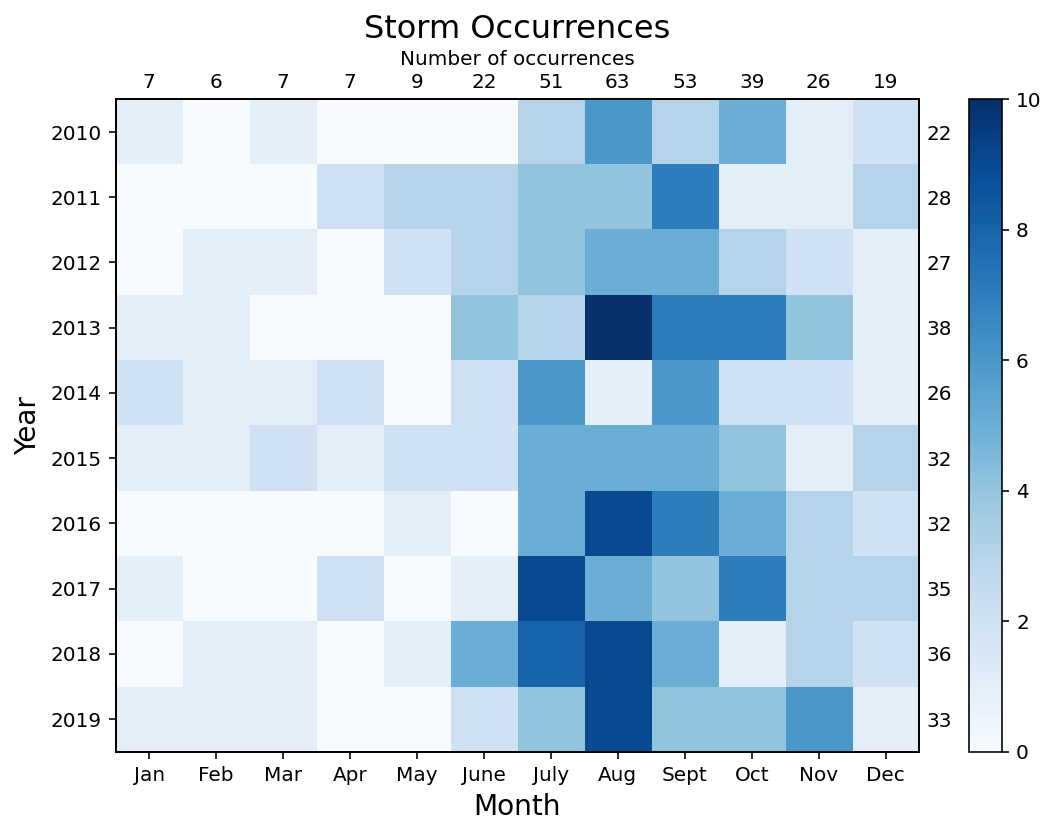

In [20]:
hi=[]
np_month = np.arange(1,13)
for year in range(10):
    for month in np_month:
        hi.append(np.sum( storm_time_initial.dt.month[storm_time_initial.dt.year.values==2010+year].values == month ))
matshow = np.reshape(hi,(10,12))
matshow = np.flip(matshow, 0)

fig, ax = plt.subplots(figsize=(9,6))
im = ax.matshow(np.flip(matshow, 0),interpolation=None,aspect='auto',cmap='Blues')

ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel('Month',fontsize=14)
months = ["Jan", "Feb", "Mar", "Apr", "May", "June", "July", 
          "Aug", "Sept", "Oct", "Nov", "Dec"]
plt.xticks(np.arange(0,12),months)

ax.set_ylabel('Year',fontsize=14)
years=np.arange(2010,2020)
plt.yticks(np.arange(0,10),years)

ax2 = ax.twiny()
ax2.set_xlabel("Number of occurrences")
ax2.set_xlim(0, 12)
ax2.set_xticks(np.linspace(0.5,11.5,12))
ax2.set_xticklabels(np.sum(matshow,axis=0))
ax2.xaxis.set_tick_params(length=0,labelbottom=False)
ax3 = ax.twinx()
#ax3.set_xlabel("Number of occurrences")
ax3.set_ylim(0,10)
ax3.set_yticks(np.linspace(0.5,9.5,10))
ax3.set_yticklabels(np.sum(matshow,axis=1))
ax3.yaxis.set_tick_params(length=0,labelbottom=False)

fig.colorbar(im, ax=ax)
plt.title('Storm Occurrences',fontsize=16)
plt.show(ax)

In [21]:
this_storm.usa_lat

<xarray.DataArray 'usa_lat' (storm: 309, date_time: 360)>
[111240 values with dtype=float32]
Coordinates:
    time     (storm, date_time) datetime64[ns] ...
    lat      (storm, date_time) float32 6.9 6.97 7.1 7.315 ... nan nan nan nan
    lon      (storm, date_time) float32 ...
Dimensions without coordinates: storm, date_time
Attributes:
    long_name:              Latitude (U.S. Agency)
    units:                  degrees_north
    coverage_content_type:  coordinate

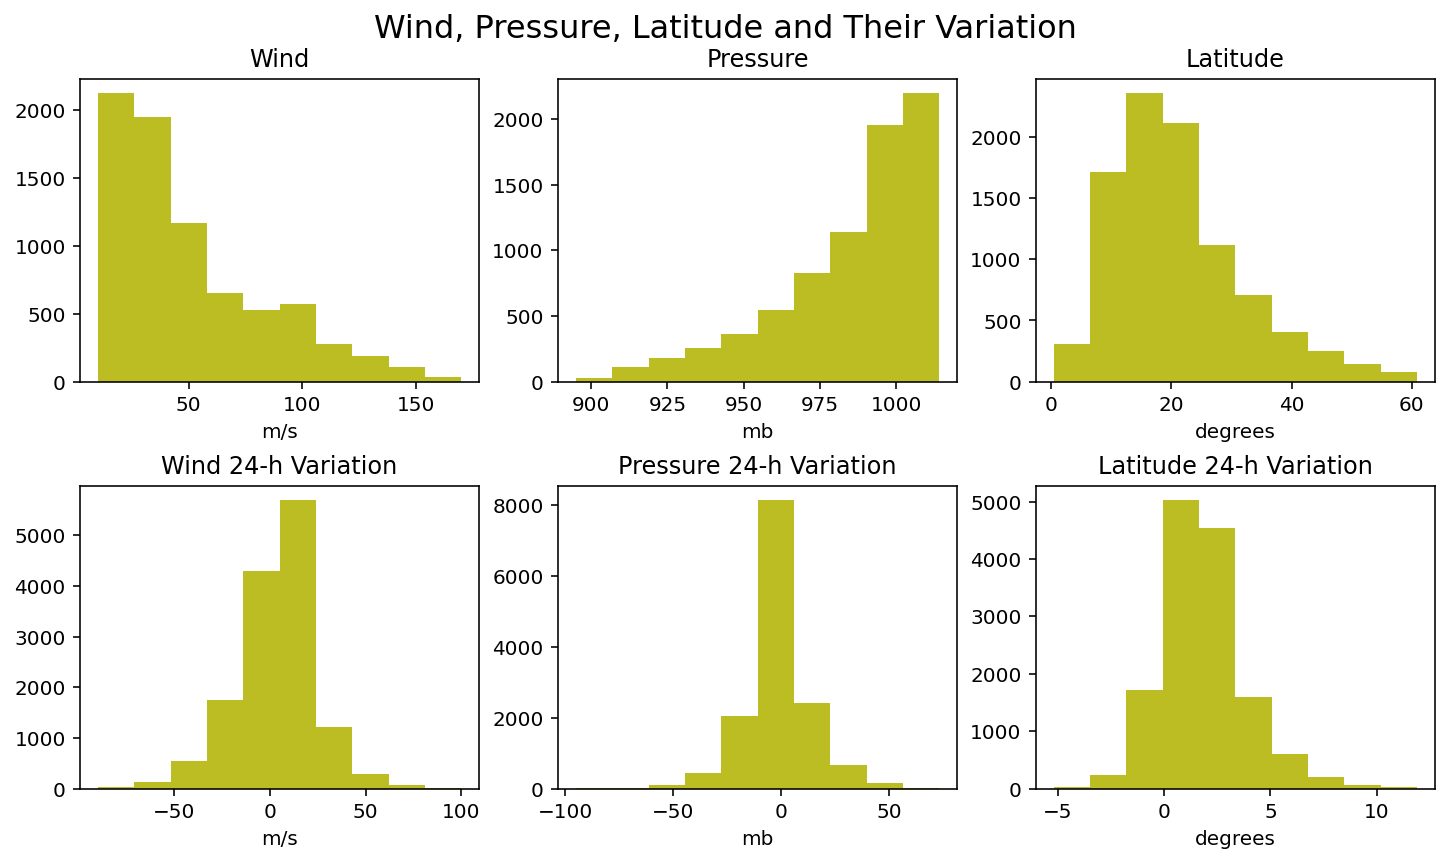

In [50]:
wind_change24 = np.array(pd.read_csv('wind_change24.csv',header=None))
pres_change24 = np.array(pd.read_csv('pres_change24.csv',header=None))
lat_change24 = np.array(pd.read_csv('lat_change24.csv',header=None))
## Computation
# wind_change24 = np.empty((309,120))
# pres_change24 = np.empty((309,120))
# lat_change24 = np.empty((309,120))
# wind_change24[:] = np.NaN
# pres_change24[:] = np.NaN
# lat_change24[:] = np.NaN
# for i in this_storm.storm:
#     for j in range(120):
#         wind_change24[i,j] = this_storm.usa_wind[i,j+8]-this_storm.usa_wind[i,j]
#         pres_change24[i,j] = this_storm.usa_pres[i,j+8]-this_storm.usa_pres[i,j]
#         lat_change24[i,j] = this_storm.usa_lat[i,j+8]-this_storm.usa_lat[i,j]

# np.savetxt("wind_change24.csv", wind_change24, delimiter=",")
# np.savetxt("pres_change24.csv", pres_change24, delimiter=",")
# np.savetxt("lat_change24.csv", lat_change24, delimiter=",")

fig, ax = plt.subplots(2, 3, figsize=(10,6))#, constrained_layout=True

ax = ax.ravel()
for i in range(9):    
    ax[0].hist(ds.usa_wind)
    ax[0].set_title('Wind')
    ax[0].set_xlabel('m/s')
    ax[1].hist(ds.usa_pres)
    ax[1].set_title('Pressure')
    ax[1].set_xlabel('mb')
    ax[2].hist(ds.latitude)
    ax[2].set_title('Latitude')
    ax[2].set_xlabel('degrees')    
    ax[3].hist(wind_change24[~np.isnan(wind_change24)])
    ax[3].set_title('Wind 24-h Variation')
    ax[3].set_xlabel('m/s')
    ax[4].hist(pres_change24[~np.isnan(pres_change24)])
    ax[4].set_title('Pressure 24-h Variation')
    ax[4].set_xlabel('mb')
    ax[5].hist(lat_change24[~np.isnan(lat_change24)])
    ax[5].set_title('Latitude 24-h Variation')
    ax[5].set_xlabel('degrees')   
#     fig.colorbar(con,ax=ax)

#fig.colorbar(im, ax=ax.ravel().tolist())
fig.suptitle('Wind, Pressure, Latitude and Their Variation',fontsize=16)
fig.tight_layout(pad=0.5)
plt.show()

In [23]:
u_shear = ds.u_200-ds.u_850
u_shear_reshape=np.reshape(np.array(u_shear),(9214,3721))

# Z-score normalization
z_norm_u_shear = (u_shear_reshape-np.mean(u_shear_reshape))/np.std(u_shear_reshape)

In [24]:
nrows = 2
ncols = 3
nodes = nrows*ncols
som = MiniSom(nrows, ncols, 3721, sigma=1.,
              learning_rate=0.2, neighborhood_function='bubble')  # 3x3 = 9 final colors
som.random_weights_init(z_norm_u_shear)
starting_weights = som.get_weights().copy()  # saving the starting weights
#som.train(z_norm_u_shear, 10000, random_order=True)#, verbose=True)
som.train_batch(z_norm_u_shear, 500, verbose=True)

print('quantization...')
qnt = som.quantization(z_norm_u_shear)  # quantize each pixels of the image
print('building new image...')
clustered = np.zeros((51,100))
#print(qnt)
# for i, q in enumerate(qnt):  # place the quantized values into a new image
#     clustered[np.unravel_index(i, shape=(51, 100))] = q
# print('done.')

som_shape = (nrows, ncols)
winner_coordinates = np.array([som.winner(x) for x in z_norm_u_shear]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape) # give each grid a cluster_index

 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 48.05682520150971
quantization...
building new image...


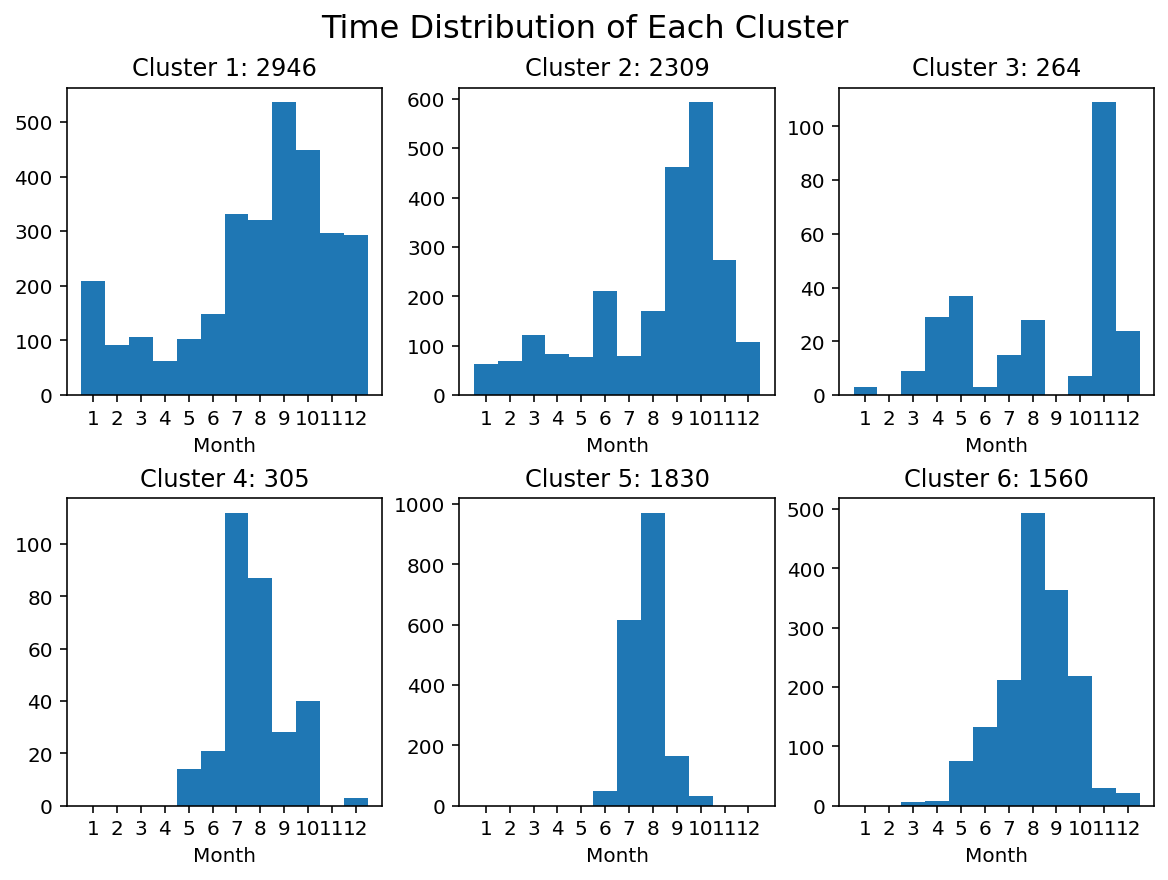

In [39]:
#plt.style.use('seaborn')
fig, ax = plt.subplots(nrows, ncols, constrained_layout=True,figsize=(8,6))

ax = ax.ravel()
for i in range(nodes):    
    plt.setp(ax, xticks=np.arange(1,13))
    ax[i].hist(ds.time[cluster_index==i].dt.month,bins=np.arange(13)+0.5)
    ax[i].set_title("Cluster "+str(i+1)+': '+str(np.sum(cluster_index==i)))
    ax[i].set_xlabel('Month')

#   fig.colorbar(con,ax=ax)

fig.suptitle('Time Distribution of Each Cluster',fontsize=16)
plt.show()
### 每个cluster总发生数

In [26]:
## Save the cluster index in the order of storms

storm_index = np.array(pd.read_csv('storm_index.csv',header=None))

np.max(np.sum(~np.isnan(storm_index),axis=1))
# storm_index0 = np.empty((309,360))
# storm_index0[:] = np.NaN
# k=0

# for i in this_storm.storm:
#     for j in this_storm.date_time:
#         if k==9213:
#             break;
#         if this_storm.time[i,j]-39936 == ds.time[k]:
#             storm_index0[i,j] = cluster_index[k]+1
            
#             k+=1
#         else:
#             continue
# storm_index = storm_index0[:,::2]
# np.savetxt("storm_index.csv", storm_index, delimiter=",")

### Lost last 30 storms

108

/tmp/ipykernel_27290/40682228.py:4: RuntimeWarning: invalid value encountered in long_scalars
  fraction_hist[i].append(np.sum(storm_index[m]==i+1)/np.sum(~np.isnan(storm_index[m])))


Text(0.5, 0, 'Frequency')

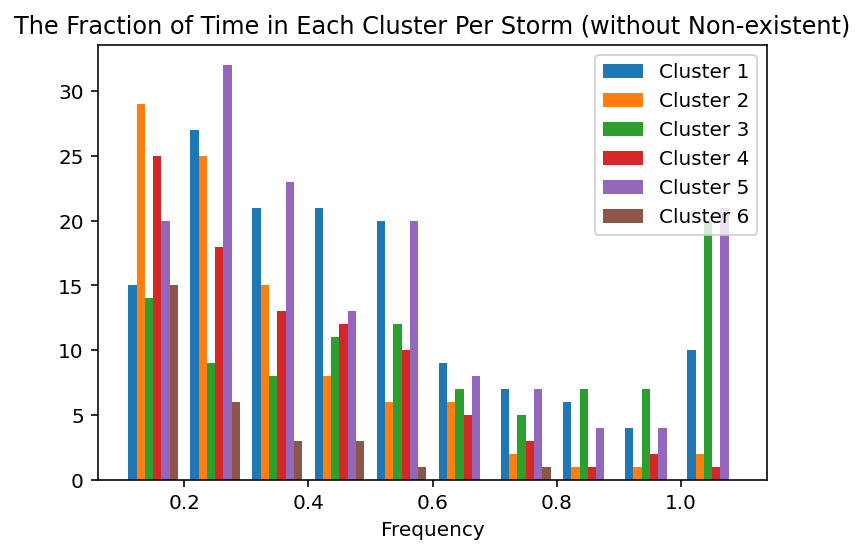

In [27]:
fraction_hist=[[],[],[],[],[],[]]
for m in range(len(storm_index[:,0])):
    for i in range(nodes):
        fraction_hist[i].append(np.sum(storm_index[m]==i+1)/np.sum(~np.isnan(storm_index[m])))
        
bins = np.arange(0.1,1.2,0.1)
plt.hist(fraction_hist,bins=bins,label=['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6',])
plt.legend()
plt.title('The Fraction of Time in Each Cluster Per Storm (without Non-existent)')
plt.xlabel('Frequency')

In [28]:
## Calculate the mean lat/lon for each cluster into lats/lons

lats = np.zeros(nodes)
lons = np.zeros(nodes)
for i in range(nodes):
    lats[i] = ds.latitude[cluster_index==i].mean() 
    lons[i] = ds.longitude[cluster_index==i].mean()

/tmp/ipykernel_27290/2400524030.py:11: RuntimeWarning: invalid value encountered in long_scalars
  if np.sum(storm_index[m]==i+1)/np.sum(~np.isnan(storm_index[m]))>0.5:


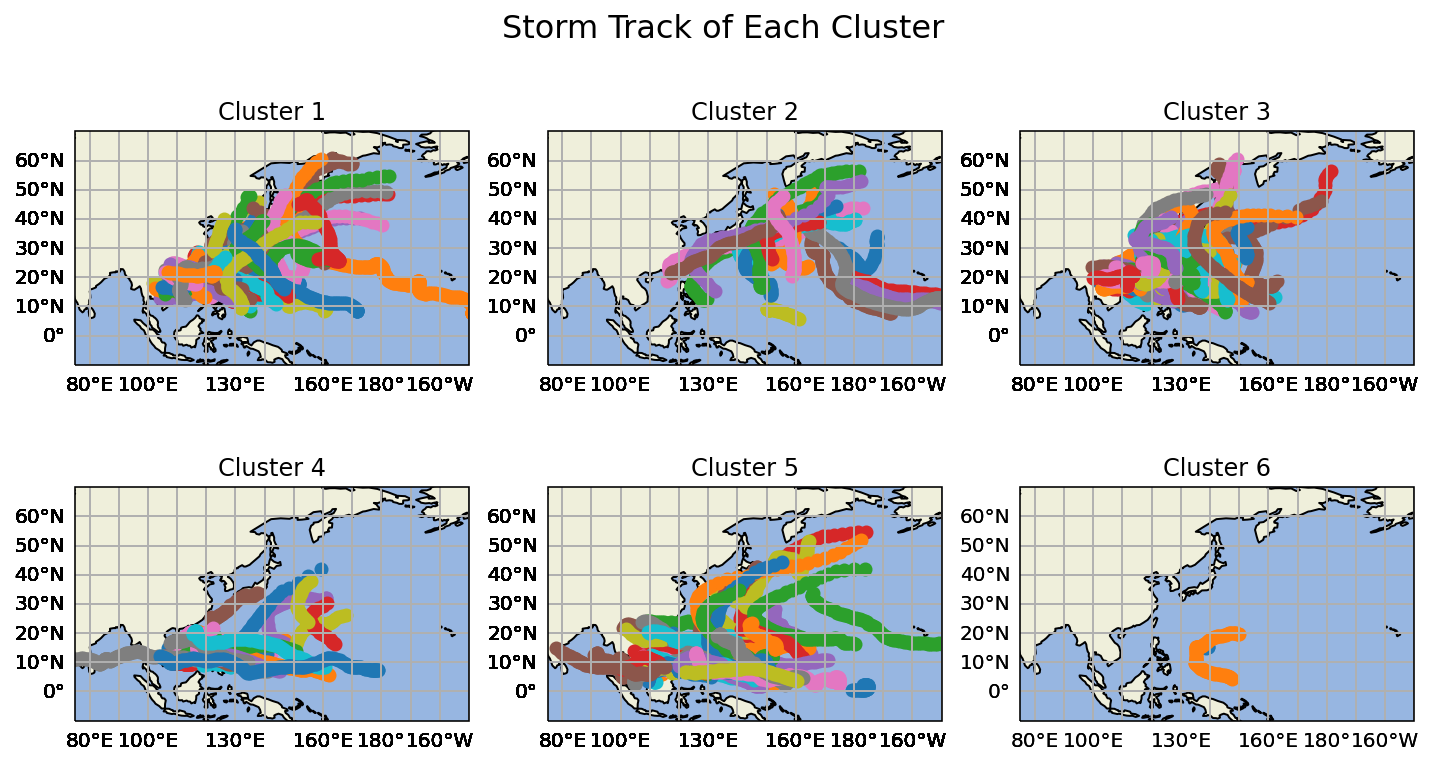

In [94]:
# If a storm is in cluster 1 80% of the time, I can assign the storm as cluster 1, and make their tracks
assign_index = np.empty((309))
assign_index[:] = np.NaN

usemap_proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4,nrows*3),subplot_kw={'projection':usemap_proj})
ax = ax.ravel()

for m in range(len(storm_index[:,0])):
    for i in range(6):
        if np.sum(storm_index[m]==i+1)/np.sum(~np.isnan(storm_index[m]))>0.5:
            assign_index[m]=i+1
            
            im = ax[i].scatter(this_storm.lon[m]-180, this_storm.lat[m])

            ax[i].add_feature(cfeature.OCEAN, zorder=0)
            ax[i].add_feature(cfeature.LAND, zorder=0, edgecolor='black')
            ax[i].set_global()
            ax[i].gridlines()
            ax[i].set_xlim(75-180,30)
            ax[i].set_ylim(-10,70)
            ax[i].set_title("Cluster "+str(i+1))

            gl = ax[i].gridlines(xlocs = np.arange(-180,180,10), ylocs = np.arange(-90,90,10), draw_labels=True, x_inline=False, y_inline=False)
            gl.top_labels = False
            gl.right_labels = False
            
fig.suptitle('Storm Track of Each Cluster',fontsize=16)
plt.show()

[[1675.   74.   54.    9.   26.    0.]
 [  92. 2284.   40.   19.    0.   50.]
 [  23.   78. 1929.   78.    0.   49.]
 [  28.   29.   28.  850.    6.   25.]
 [  12.    0.    0.    0.  139.    0.]
 [  10.   40.   17.   48.    0.  722.]]


Text(0.5, 1.0, 'Transition Chart')

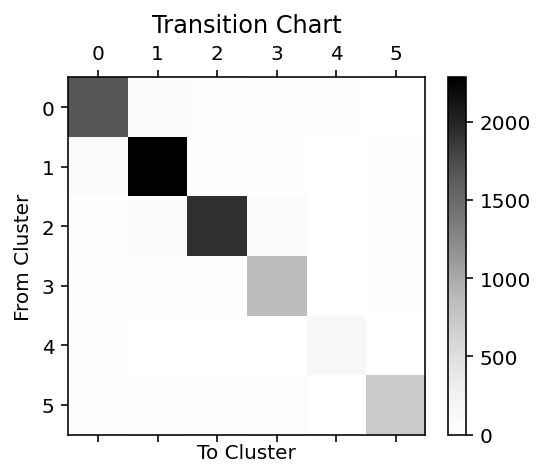

In [100]:
## Create transition table

transition_table = np.array(pd.read_csv('transition_table.csv',header=None))
print(transition_table)
plt.matshow(transition_table,cmap='Greys')
plt.colorbar(shrink=0.8)
plt.xlabel('To Cluster')
plt.ylabel('From Cluster')
plt.title('Transition Chart')
# transition_table = np.zeros((nodes,nodes))
# for i in range(278):
#     for j in range(105):
#         if storm_index[i,j+1]!=0:
#             #print(int(storm_index[i,j]))
#             transition_table[ int(storm_index[i,j])-1, int(storm_index[i,j+1])-1 ] +=1

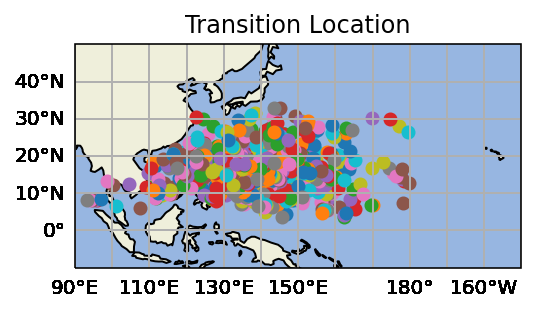

In [32]:
usemap_proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(figsize=(4,5),subplot_kw={'projection':usemap_proj})

for i in range(309):
    for j in range(120):
        if np.isnan(storm_index[i,j]) == False and np.isnan(storm_index[i,j+1]) == False and storm_index[i,j] != storm_index[i,j+1]:
            #print(storm_index[i,j],storm_index[i,j+1])
            ax.scatter(this_storm.usa_lon[i,j]-180,this_storm.usa_lat[i,j])
            
            ax.add_feature(cfeature.OCEAN, zorder=0)
            ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
            ax.set_global()
            ax.gridlines()
            ax.set_xlim(-90,30)
            ax.set_ylim(-10,50)
            ax.set_title('Transition Location')

            gl = ax.gridlines(xlocs = np.arange(-180,180,10), ylocs = np.arange(-90,90,10), draw_labels=True, x_inline=False, y_inline=False)
            gl.top_labels = False
            gl.right_labels = False

            gl = ax.gridlines(xlocs = np.arange(-180,180,10), ylocs = np.arange(-90,90,10), draw_labels=True, x_inline=False, y_inline=False)
            gl.top_labels = False
            gl.right_labels = False

In [73]:
mean_wind_change = np.zeros(nodes)
max_wind_change = np.zeros(nodes)
min_wind_change = np.zeros(nodes)
for i in range(nodes):
    mean_wind_change[i] = np.nanmean(wind_change24[storm_index==i+1])
    max_wind_change[i] = np.nanmax(wind_change24[storm_index==i+1])
    min_wind_change[i] = np.nanmin(wind_change24[storm_index==i+1])
    
mean_pres_change = np.zeros(nodes)
max_pres_change = np.zeros(nodes)
min_pres_change = np.zeros(nodes)
for i in range(nodes):
    mean_pres_change[i] = np.nanmean(pres_change24[storm_index==i+1])
    max_pres_change[i] = np.nanmax(pres_change24[storm_index==i+1])
    min_pres_change[i] = np.nanmin(pres_change24[storm_index==i+1])
    
mean_lat_change = np.zeros(nodes)
max_lat_change = np.zeros(nodes)
min_lat_change = np.zeros(nodes)
for i in range(nodes):
    mean_lat_change[i] = np.nanmean(lat_change24[storm_index==i+1])
    max_lat_change[i] = np.nanmax(lat_change24[storm_index==i+1])
    min_lat_change[i] = np.nanmin(lat_change24[storm_index==i+1])
    
### The storm weakening records are less then strengthening records

In [89]:
import openpyxl
stats = pd.DataFrame((mean_wind_change,max_wind_change,min_wind_change, 
              mean_pres_change,max_pres_change,min_pres_change, 
              mean_lat_change,max_lat_change,min_lat_change),
            columns=['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6'],
            index=['Mean change','Max change','Min change','Mean change','Max change','Min change',
                   'Mean change','Max change','Min change',]).T
stats.to_excel('stats.xlsx')

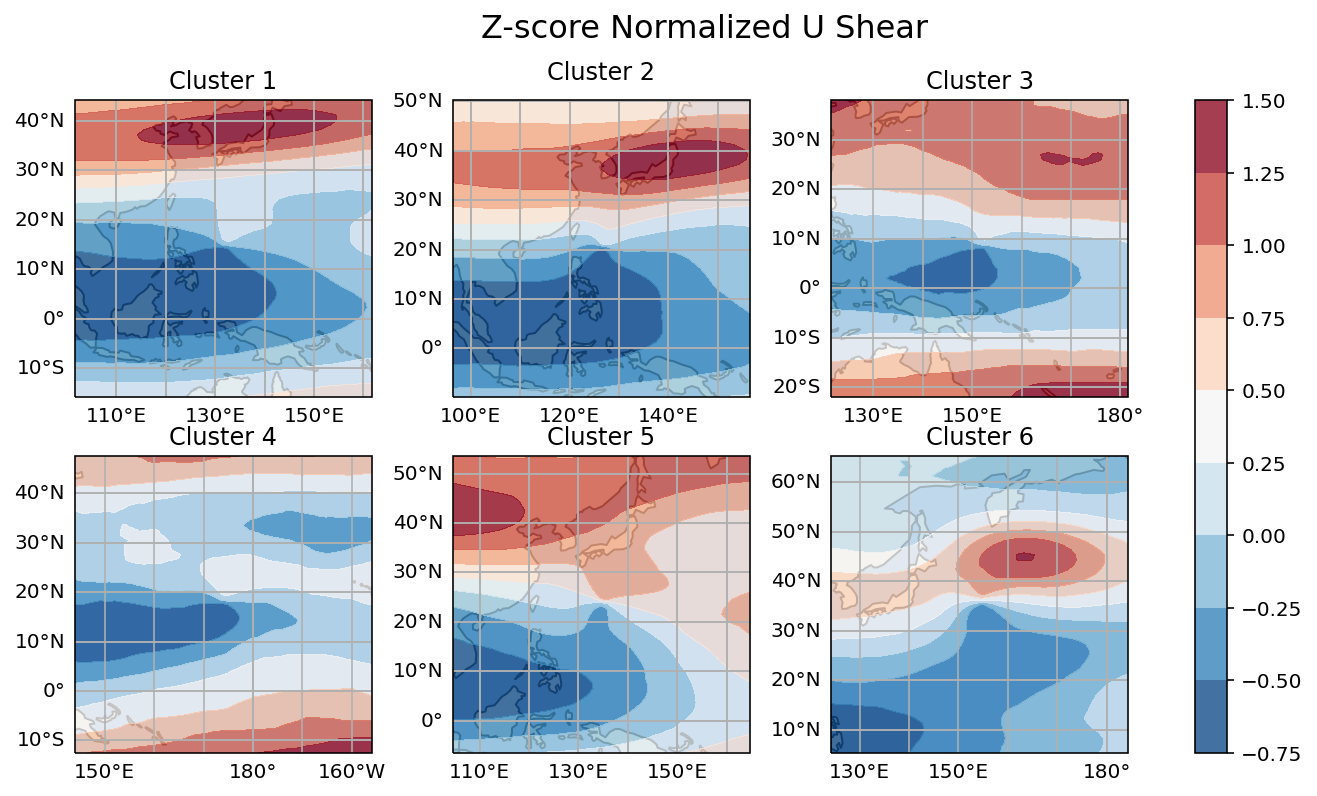

In [44]:
#sns.set_style("whitegrid")
#sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

usemap_proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4,nrows*3),subplot_kw={'projection':usemap_proj})
ax = ax.ravel()

for i in range(nodes):
    loni = np.linspace(lons[i]-30, lons[i]+30,61)
    lati = np.linspace(lats[i]-30, lats[i]+30,61)

    patterni = np.reshape(np.mean(z_norm_u_shear[cluster_index==i],axis=0),(61,61))

    im = ax[i].contourf(loni-180, lati, patterni, cmap = plt.get_cmap('RdBu_r'),alpha=0.8)
    
    ax[i].add_feature(cfeature.OCEAN, zorder=0)
    ax[i].add_feature(cfeature.LAND, zorder=0, edgecolor='black')
    ax[i].set_global()
    ax[i].gridlines()
    ax[i].set_xlim(lons[i]-210,lons[i]-150)
    ax[i].set_ylim(lats[i]-30,lats[i]+30)
    ax[i].set_title("Cluster "+str(i+1))
    
    gl = ax[i].gridlines(xlocs = np.arange(-180,180,10), ylocs = np.arange(-90,90,10), draw_labels=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False
    
fig.colorbar(im, ax=ax.ravel().tolist())
fig.suptitle('Z-score Normalized U Shear',fontsize=16)
plt.show()

### Panel 4: Lon exceeds 180 degrees

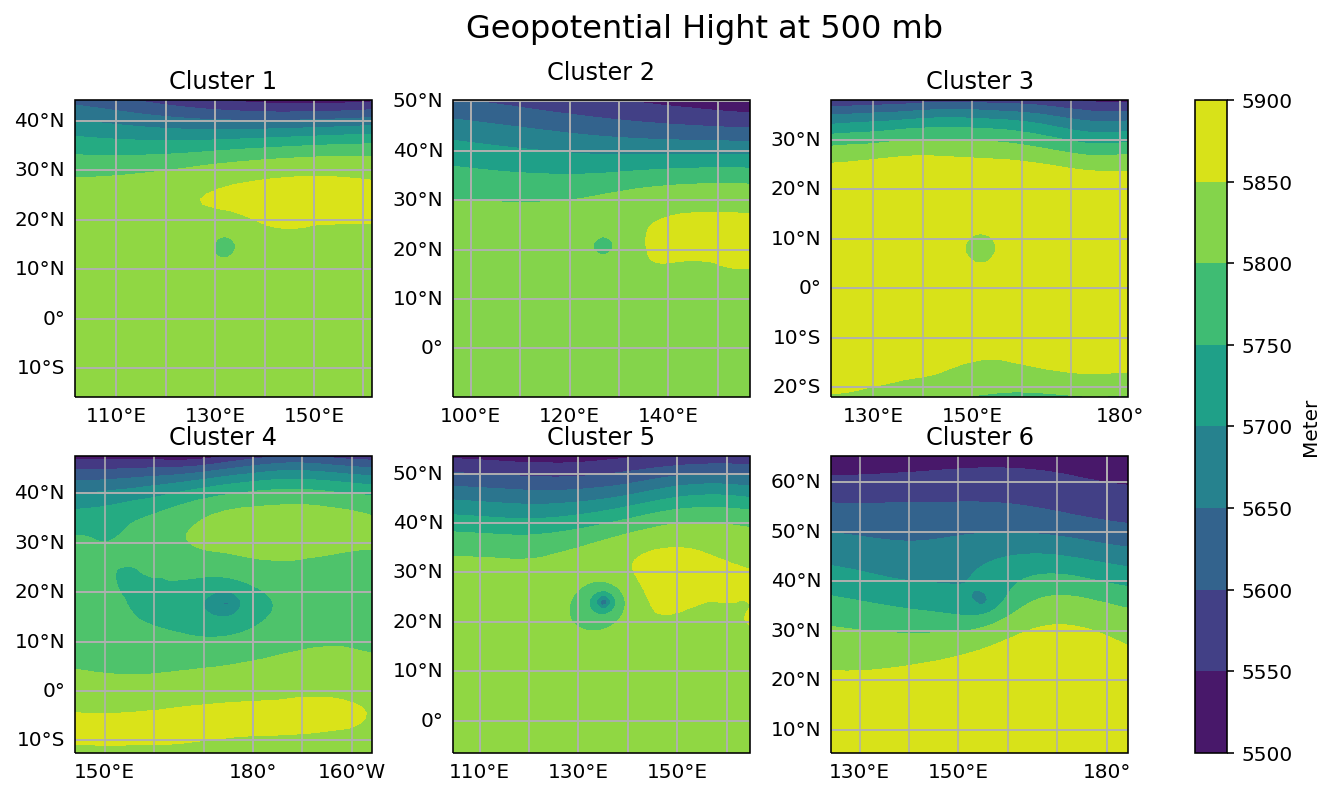

In [48]:
#sns.set_style("whitegrid")
#sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
usemap_proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4,nrows*3),subplot_kw={'projection':usemap_proj})
ax = ax.ravel()

for i in range(nodes):
    loni = np.linspace(lons[i]-30, lons[i]+30,61)
    lati = np.linspace(lats[i]-30, lats[i]+30,61)
    
    im = ax[i].contourf(loni-180, lati, np.mean(ds.gh_500[cluster_index == i], axis=0))
    
    ax[i].add_feature(cfeature.OCEAN, zorder=0)
    ax[i].add_feature(cfeature.LAND, zorder=0, edgecolor='black')
    ax[i].set_global()
    ax[i].gridlines()
    ax[i].set_xlim(lons[i]-210,lons[i]-150)
    ax[i].set_ylim(lats[i]-30,lats[i]+30)
    ax[i].set_title("Cluster "+str(i+1))
    
    gl = ax[i].gridlines(xlocs = np.arange(-180,180,10), ylocs = np.arange(-90,90,10), draw_labels=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False
    
fig.colorbar(im, ax=ax.ravel().tolist(),label='Meter')
fig.suptitle('Geopotential Hight at 500 mb',fontsize=16)
plt.show()

### Panel 4: Lon exceeds 180 degrees
### Colorbar and cmap different

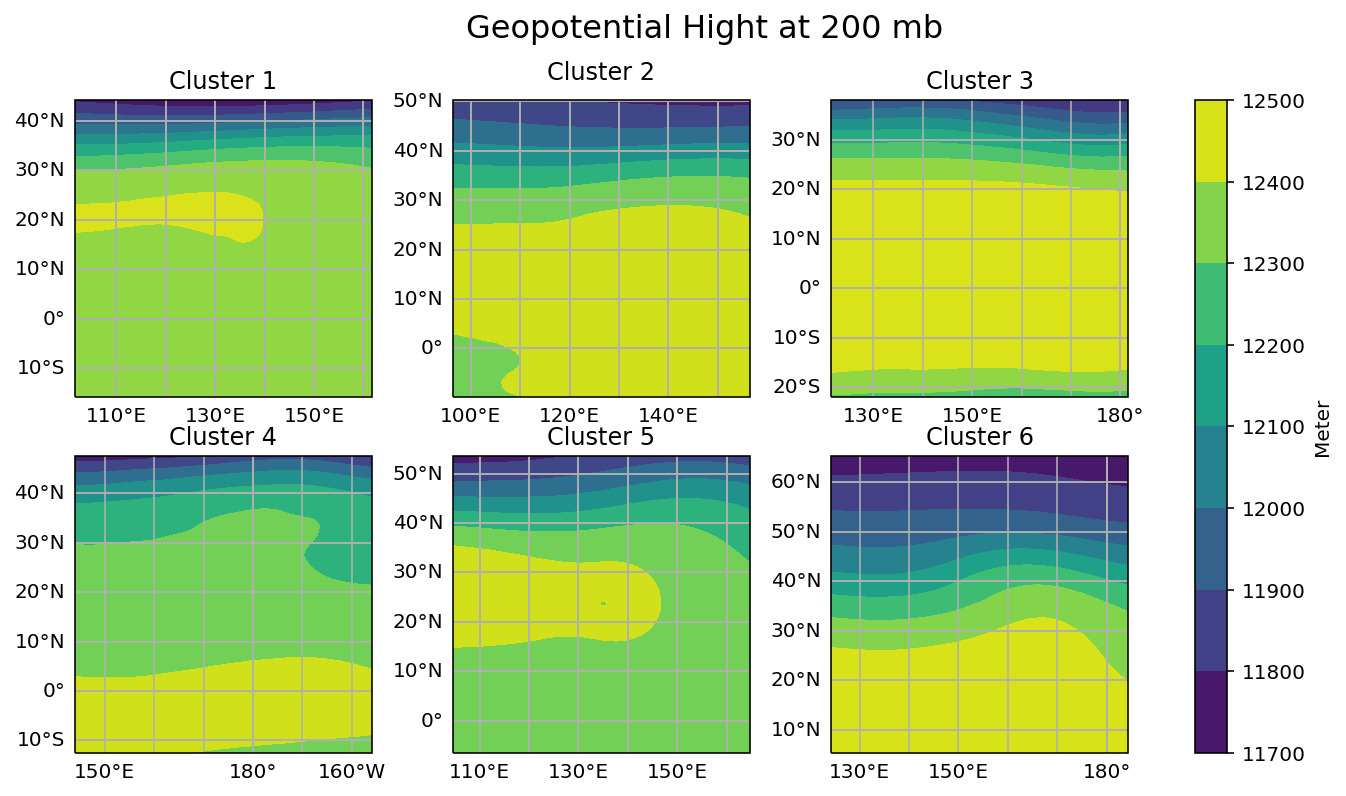

In [49]:
#sns.set_style("whitegrid")
#sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
usemap_proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4,nrows*3),subplot_kw={'projection':usemap_proj})
ax = ax.ravel()

for i in range(nodes):
    loni = np.linspace(lons[i]-30, lons[i]+30,61)
    lati = np.linspace(lats[i]-30, lats[i]+30,61)
    
    im = ax[i].contourf(loni-180, lati, np.mean(ds.gh_200[cluster_index == i], axis=0))
    
    ax[i].add_feature(cfeature.OCEAN, zorder=0)
    ax[i].add_feature(cfeature.LAND, zorder=0, edgecolor='black')
    ax[i].set_global()
    ax[i].gridlines()
    ax[i].set_xlim(lons[i]-210,lons[i]-150)
    ax[i].set_ylim(lats[i]-30,lats[i]+30)
    ax[i].set_title("Cluster "+str(i+1))
    
    gl = ax[i].gridlines(xlocs = np.arange(-180,180,10), ylocs = np.arange(-90,90,10), draw_labels=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False
    
fig.colorbar(im, ax=ax.ravel().tolist(),label='Meter')
fig.suptitle('Geopotential Hight at 200 mb',fontsize=16)
plt.show()

### Panel 4: Lon exceeds 180 degrees
### Colorbar and cmap different

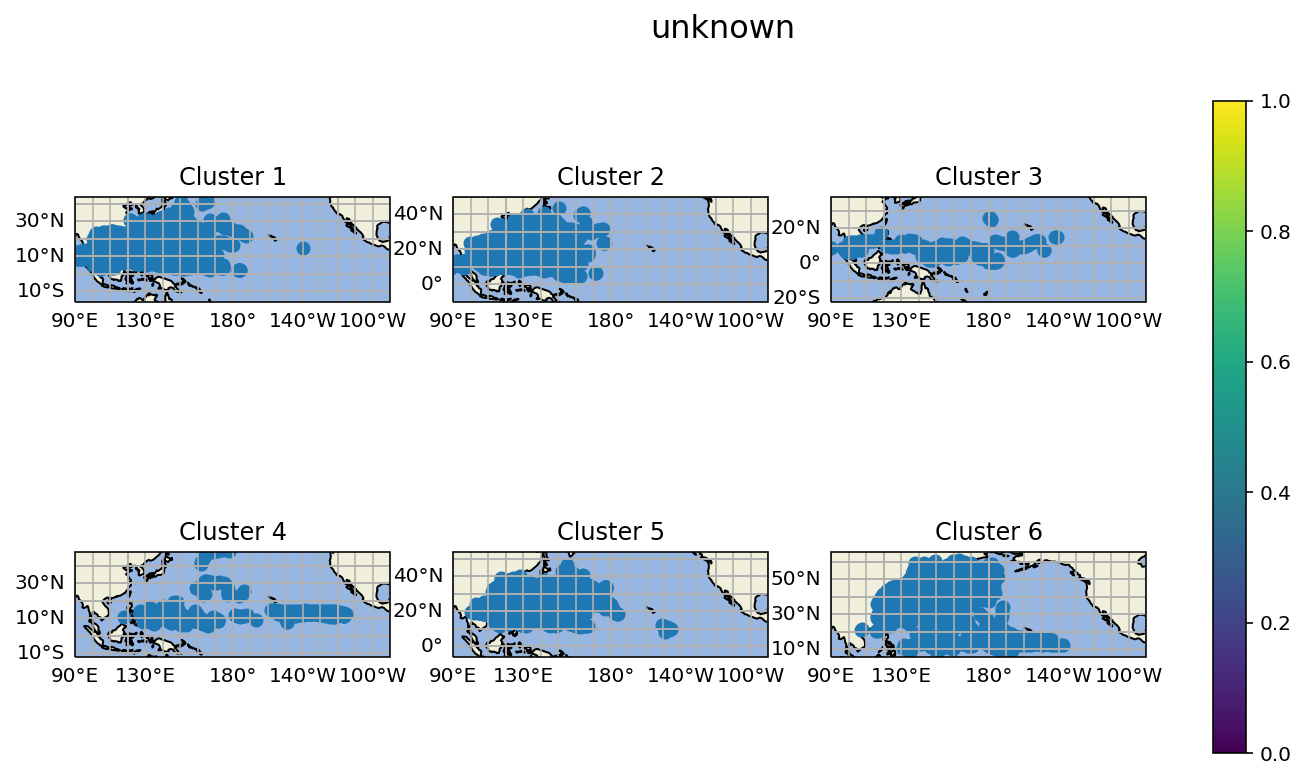

In [37]:
#sns.set_style("whitegrid")
#sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
usemap_proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4,nrows*3),subplot_kw={'projection':usemap_proj})
ax = ax.ravel()

for i in range(nodes):
    loni = np.linspace(lons[i]-30, lons[i]+30,61)
    lati = np.linspace(lats[i]-30, lats[i]+30,61)
    
    #im = ax[i].contourf(loni, lati, np.mean(ds.gh_200[cluster_index == i], axis=0))
    im = ax[i].scatter(ds.longitude[cluster_index == i]-180, ds.latitude[cluster_index == i])
    
    ax[i].add_feature(cfeature.OCEAN, zorder=0)
    ax[i].add_feature(cfeature.LAND, zorder=0, edgecolor='black')
    ax[i].set_global()
    ax[i].gridlines()
    ax[i].set_xlim(-90,90)
    ax[i].set_ylim(lats[i]-30,lats[i]+30)
    ax[i].set_title("Cluster "+str(i+1))
    
    gl = ax[i].gridlines(xlocs = np.arange(-180,180,10), ylocs = np.arange(-90,90,10), draw_labels=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False
    
fig.colorbar(im, ax=ax.ravel().tolist())
fig.suptitle('unknown',fontsize=16)
plt.show()

### Panel 4: Lon exceeds 180 degrees
### Colorbar and cmap different

In [38]:
pulse

NameError: name 'pulse' is not defined

In [ ]:
# Sklearn normalization, (I don't think it's Min-Max normalization)
skl_norm_u_shear = preprocessing.normalize(u_shear_reshape)
print(skl_norm_u_shear)

In [ ]:
som = MiniSom(3, 5, 3721, sigma=1.,
              learning_rate=0.2, neighborhood_function='bubble')  # 3x3 = 9 final colors
som.random_weights_init(skl_norm_u_shear)
starting_weights = som.get_weights().copy()  # saving the starting weights
som.train(skl_norm_u_shear, 10000, random_order=True)#, verbose=True)

print('quantization...')
qnt = som.quantization(skl_norm_u_shear)  # quantize each pixels of the image
print('building new image...')
clustered = np.zeros((51,100))
print(qnt)
# for i, q in enumerate(qnt):  # place the quantized values into a new image
#     clustered[np.unravel_index(i, shape=(51, 100))] = q
# print('done.')

In [ ]:
plt.subplot(121)
plt.contourf(skl_norm_u_shear)
plt.subplot(122)
plt.contourf(qnt)
plt.colorbar()

In [ ]:
# Min-max normalization
min_max_norm_u_shear = (u_shear_reshape-np.min(u_shear_reshape)) / (np.max(u_shear_reshape)-np.min(u_shear_reshape))

In [ ]:
som = MiniSom(5, 7, 3721, sigma=1.,
              learning_rate=0.2, neighborhood_function='bubble')  # 3x3 = 9 final colors
som.random_weights_init(min_max_norm_u_shear)
starting_weights = som.get_weights().copy()  # saving the starting weights
som.train(min_max_norm_u_shear, 10000, random_order=True)#, verbose=True)

print('quantization...')
qnt = som.quantization(min_max_norm_u_shear)  # quantize each pixels of the image
print('building new image...')
clustered = np.zeros((51,100))
print(qnt)
# for i, q in enumerate(qnt):  # place the quantized values into a new image
#     clustered[np.unravel_index(i, shape=(51, 100))] = q
# print('done.')

In [ ]:
plt.subplot(121)
plt.contourf(min_max_norm_u_shear)
plt.subplot(122)
plt.contourf(qnt)
plt.colorbar()

In [ ]:
# gh_200 min_max normalization
gh_200_reshape=np.reshape(np.array(ds.gh_200),(9214,3721))
min_max_norm_gh_200 = (gh_200_reshape-np.min(gh_200_reshape)) / (np.max(gh_200_reshape)-np.min(gh_200_reshape))

In [ ]:
som = MiniSom(15, 15, 3721, sigma=1.,
              learning_rate=0.2, neighborhood_function='bubble')  # 3x3 = 9 final colors
som.random_weights_init(min_max_norm_gh_200)
starting_weights = som.get_weights().copy()  # saving the starting weights
som.train(min_max_norm_gh_200, 10000, random_order=True)#, verbose=True)

print('quantization...')
qnt = som.quantization(min_max_norm_gh_200)  # quantize each pixels of the image
print('building new image...')
clustered = np.zeros((51,100))
print(qnt)
# for i, q in enumerate(qnt):  # place the quantized values into a new image
#     clustered[np.unravel_index(i, shape=(51, 100))] = q
# print('done.')

In [ ]:
plt.subplot(121)
plt.contourf(min_max_norm_gh_200)
plt.subplot(122)
plt.contourf(qnt)
plt.colorbar()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(5, 5))

plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
plt.colorbar()

# Plotting the response for each pattern in the iris dataset
# different colors and markers for each label
markers = ['o', 's', 'D']
colors = ['C0', 'C1', 'C2']
for cnt, xx in enumerate(min_max_norm_gh_200):
    w = som.winner(xx)  # getting the winner
    # palce a marker on the winning position for the sample xx
#     plt.plot(w[0]+.5, w[1]+.5, markers[target[cnt]-1], markerfacecolor='None',
#              markeredgecolor=colors[target[cnt]-1], markersize=12, markeredgewidth=2)

plt.show()

In [ ]:
# each neuron represents a cluster
som_shape = (15,15)
winner_coordinates = np.array([som.winner(x) for x in min_max_norm_gh_200]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

In [ ]:
(cluster_index)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# plotting the clusters using the first 2 dimentions of the data
for c in np.unique(cluster_index):
    plt.scatter(min_max_norm_gh_200[cluster_index == c, 0],
                min_max_norm_gh_200[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# plotting centroids
for centroid in som.get_weights():
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='x', 
                s=80, linewidths=35, color='k', label='centroid')
plt.legend();

In [ ]:
W = som.get_weights()
plt.figure(figsize=(5, 5))
for i in range(W.shape[2]):
    plt.pcolor(W[:,:,i].T, cmap='coolwarm')
#     plt.xticks(np.arange(size+1))
#     plt.yticks(np.arange(size+1))
plt.tight_layout()
plt.show()

In [ ]:
som = MiniSom(15, 15, 3721, sigma=1.,
              learning_rate=0.2, neighborhood_function='bubble')  # 3x3 = 9 final colors
som.random_weights_init(z_norm_u_shear)
starting_weights = som.get_weights().copy()  # saving the starting weights
som.train(z_norm_u_shear, 10000, random_order=True)#, verbose=True)

print('quantization...')
qnt = som.quantization(z_norm_u_shear)  # quantize each pixels of the image
print('building new image...')
clustered = np.zeros((51,100))
print(qnt)
# for i, q in enumerate(qnt):  # place the quantized values into a new image
#     clustered[np.unravel_index(i, shape=(51, 100))] = q
# print('done.')

In [ ]:
W = som.get_weights()
plt.figure(figsize=(5, 5))
for i in range(1):
    plt.pcolor(W[:,:,i].T, cmap='coolwarm')
#     plt.xticks(np.arange(size+1))
#     plt.yticks(np.arange(size+1))
plt.tight_layout()
plt.show()